# Control strategies for Fokker-Planck equation

The Fokker-Planck equation studied is 
$$
\rho_t = \nabla \cdot (\nu \nabla \rho + \rho \nabla V), x \in \Omega, t \ge 0,
$$
where $J(x,t) = \nu \nabla \rho(x,t) + \rho(x,t) \nabla V(x,t)$ is the probability flux and 
$$
V(x,t) = G(x) + \alpha(x) u(t),
$$
where $G$ is the potential function, $\alpha$ is the control shape function and $u$ is the time-dependent control function.
Moreover, the probability flux is zero in the boundary, that is
$$
(\nu \nabla \rho(x,t) + \rho(x,t) \nabla G(x)) \cdot \vec{n} = 0, \nabla \alpha \cdot \vec{n} = 0, x \in \partial \Omega, t \ge 0.
$$

The uncontrolled version converges to the distribution 
$$
\rho_{\infty}(x) \propto e^{-G(x)/\nu}.
$$

In [1]:
import numpy as np

from scipy.integrate import quad, solve_ivp, ode
from scipy.stats import norm, truncnorm, beta
from scipy.linalg import solve_banded, solve_continuous_are
from scipy.special import legendre
from scipy.interpolate import lagrange
from scipy.optimize import newton

import matplotlib.pyplot as plt
from tqdm import tqdm

Define 
$$
y(x,t) = \rho(x,t) - \rho_{\infty}(x),
$$
and we get the equation 
$$
y_t = \nabla \cdot (\nu \nabla y + y \nabla G) + u(t) \nabla \cdot (y \nabla \alpha + \rho_{\infty} \nabla \alpha),
$$
with $\nabla \cdot (\nu \nabla y + y \nabla G) = 0$ in the boundary.

The bilinear abstract control system is
$$
\dot{y} = \mathcal{A}y + u\mathcal{N}y + \mathcal{B}u.
$$

The weak formulation of this equation is $\forall \phi \in H^1(\Omega),$

$$
\langle \dot{y}, \phi \rangle = \langle \mathcal{A}y, \phi \rangle + u\langle \mathcal{N}y, \phi \rangle + \langle \mathcal{B}u, \phi\rangle
$$

and using Integration by Parts,

$$
\langle y_t, \phi \rangle = - \langle \nu \nabla y + y \nabla G, \nabla \phi \rangle - u(t) \langle y \nabla \alpha, \nabla \phi \rangle - u(t) \langle \rho_{\infty} \nabla \alpha, \nabla \phi \rangle,
$$

We consider an approximation 
$$
y(x,t) \approx \sum_{j=0}^{n-2} y_j(t) \phi_j(x),
$$

where $\phi_j(x) = L_j(x) + \alpha_j(x) L_{j+1}(x) + \beta L_{j+2}(x)$ and $L_k$ is the Legendre polynomial of order $k$.

In [2]:
class ControlFPequation:
    
    def __init__(self, G_func, alpha_func, parameters) -> None:
        
        self.G = G_func
        self.G_x = None
        self.alpha = alpha_func
        self.alpha_x = None
        self.v = parameters['v']
        self.T = parameters['T']
        self.p0 = parameters['p_0']
        self.p_infty = self._calculus_steady_state()
        
        self.Phi = None
        self.A = None
        self.y0 = None

    def _calculus_steady_state(self):

        c = 1/quad(lambda x: np.exp(-self.G(x)/self.v), a=-1.0, b=1.0)[0]
        p_infty = lambda x: c*np.exp(-self.G(x)/self.v)
        return p_infty
    
    def _update_with_boundary_conditions(self, i, j, M):
        aux = M[i,j] + self.coef[i,0]*M[i+1,j] + self.coef[i,1]*M[i+2,j] 
        aux += self.coef[j,0]*M[i,j+1] + self.coef[i,0]*self.coef[j,0]*M[i+1,j+1] + self.coef[i,1]*self.coef[j,0]*M[i+2,j+1]
        aux += self.coef[j,1]*M[i,j+2] + self.coef[i,0]*self.coef[j,1]*M[i+1,j+2] + self.coef[i,1]*self.coef[j,1]*M[i+2,j+2]
        return aux

Now we discretize the operators:

$$
\sum_{j=0}^{n-2} \dot{y}_j(t) \langle \phi_j, \phi_i \rangle = \sum_{j=0}^{n-2} y_j(t) \langle \mathcal{A}\phi_j, \phi_i \rangle + u(t) \sum_{j=0}^{n-2} y_j(t) \langle \mathcal{N}\phi_j, \phi_i \rangle + \langle \mathcal{B}u(t), \phi_i\rangle, 
$$

which can be rewritten as 

$$
\Phi \dot{y} = Ay + uNy + Bu,
$$

or using Integration by Parts
$$
\sum_{j=0}^{n-2} \dot{y}_j(t) \langle \phi_j, \phi_i \rangle = - \sum_{j=0}^{n-2} y_j(t) \langle \nu \nabla \phi_j + \phi_j \nabla G, \nabla \phi_i \rangle - u(t) \sum_{j=0}^{n-2} y_j(t) \langle \phi_j \nabla \alpha, \nabla \phi_i \rangle - u(t) \langle \rho_{\infty} \nabla \alpha, \nabla \phi_i \rangle.
$$

Moreover, we want to $\phi_i$ to verify the boundary condition at $\pm 1$, that is, 

$$
\nu \dot{\phi}_j(\pm 1) + \phi_j(\pm 1) \dot{G}(\pm 1) = 0, \forall j=0,\dots,n-2,
$$

which defines the coefficients $\alpha_j, \beta_j$.

One additional observation is that 

$$
\int_{\Omega} y(x,t) \, dx = 0, \forall t \ge 0.
$$

by definition.
The approximation for $y$ implies
$$
\int_{-1}^1 \sum_{j=0}^{n-2} y_j(t) \phi_j(x) \, dx = \sum_{j=0}^{n-2} y_j(t) \left[\int_{-1}^1 \phi_j(x) \, dx  + \alpha_j \int_{-1}^1 \phi_{j+1}(x) \, dx + \beta_j \int_{-1}^1 \phi_{j+2}(x) \, dx \right] = 2 y_0(t).
$$

So, for approximation of $y$, we might not consider the Legendre polynomial of order $0$.

In [22]:
def _solve_system_coefs_spectral_legendre(self, n_f, Gxl, Gxu):
    coef = np.zeros((n_f-1,2))
    for k in range(n_f-1):
        M = np.array([
            [self.v*(k+1)*(k+2) - 2*Gxl, -self.v*(k+2)*(k+3) + 2*Gxl],
            [self.v*(k+1)*(k+2) + 2*Gxu, self.v*(k+2)*(k+3) + 2*Gxu],
        ])
        m = np.array([self.v*k*(k+1) - 2*Gxl, -self.v*k*(k+1) - 2*Gxu])
        coef[k] = np.linalg.solve(M, m)
    return coef

def _discretize_Phi(self, n_f):
    L = np.diag(2/(2*np.linspace(0,n_f,n_f+1)+1))
    Phi = np.zeros((n_f-1, n_f-1))
    for i in range(n_f-1):
        for j in range(n_f-1):
            Phi[i,j] = self._update_with_boundary_conditions(i, j, L)
    return Phi

def _discretize_A(self,n_f):
    L_dot = np.zeros((n_f+1, n_f+1))
    G_dot_L = np.zeros((n_f+1, n_f+1))
    for i in range(n_f+1):
        for j in range(n_f+1):
            L_dot[i,j] = min(i,j)*(min(i,j)+1)*((i+j)%2==0)
            G_dot_L[i,j] = quad(func=lambda x: self.G_x(x)*self.legendre_family[j](x)*self.legendre_family_diff[i](x), a=-1, b=1)[0]
    Lambda = np.zeros((n_f-1, n_f-1))
    Theta1 = np.zeros((n_f-1, n_f-1))
    for i in range(n_f-1):
        for j in range(n_f-1):
            Lambda[i,j] = self.v*self._update_with_boundary_conditions(i, j, L_dot)
            Theta1[i,j] = self._update_with_boundary_conditions(i, j, G_dot_L)
    return -(Lambda + Theta1)

def _discretize_N(self, n_f, lim1=-0.99, lim2=0.99):
    alpha_dot_L = np.zeros((n_f+1, n_f+1))
    for i in range(n_f+1):
        for j in range(n_f+1):
            alpha_dot_L[i,j] = quad(func=lambda x: self.legendre_family[j](x)*self.legendre_family_diff[i](x), a=lim1, b=lim2)[0]
    Theta2 = np.zeros((n_f-1, n_f-1))
    for i in range(n_f-1):
        for j in range(n_f-1):
            Theta2[i,j] = self._update_with_boundary_conditions(i, j, alpha_dot_L)
    return -Theta2

def _discretize_B(self, n_f, lim1=-0.99, lim2=0.99):
    steady_L = np.zeros(n_f+1)
    for i in range(n_f+1):
        steady_L[i] = quad(func=lambda x: self.p_infty(x)*self.legendre_family_diff[i](x), a=lim1, b=lim2)[0]
    B = np.zeros((n_f-1,1))
    for i in range(n_f-1):
        B[i,0] = -(steady_L[i] + self.coef[i,0]*steady_L[i+1] + self.coef[i,1]*steady_L[i+2])
    return B

def _discretize_initial_condition(self, n_f, Phi):
    y0 = lambda x: self.p0(x) - self.p_infty(x)
    y0_L = np.zeros(n_f+1)
    for i in range(n_f+1):
        y0_L[i] = quad(func=lambda x: y0(x)*self.legendre_family[i](x), a=-1, b=1)[0]
    b = np.zeros(n_f-1)
    for i in range(n_f-1):
        b[i] = y0_L[i] + self.coef[i,0]*y0_L[i+1] + self.coef[i,1]*y0_L[i+2]
    y0 = np.linalg.solve(Phi, b)
    return y0
    
ControlFPequation._solve_system_coefs_spectral_legendre = _solve_system_coefs_spectral_legendre
ControlFPequation._discretize_Phi = _discretize_Phi
ControlFPequation._discretize_A = _discretize_A
ControlFPequation._discretize_N = _discretize_N
ControlFPequation._discretize_B = _discretize_B
ControlFPequation._discretize_initial_condition = _discretize_initial_condition

After the pre-calculation step, we can define the solving function.

In [35]:
def _solve1d_edo(self, n_f, N_x, N_t, lim1=None, lim2=None, controlled=True):
    
    self.legendre_family = [legendre(k) for k in range(n_f+1)]
    self.legendre_family_diff = [np.polyder(poly, 1) for poly in self.legendre_family]
    self.coef = self._solve_system_coefs_spectral_legendre(n_f, self.G_x(-1.0), self.G_x(1.0))
    
    h_t = self.T/N_t
    h_x = 2/N_x
    
    if self.Phi is None:
        self.Phi = self._discretize_Phi(n_f)
        self.Phi_inv = np.linalg.inv(self.Phi)
        self.A = self._discretize_A(n_f)
        self.y0 = self._discretize_initial_condition(n_f, self.Phi)
            
    if controlled:
        B = self._discretize_B(n_f, lim1, lim2)
        N = self._discretize_N(n_f, lim1, lim2)
        Pi = solve_continuous_are(a=self.A, b=B, q=self.Phi, r=1)
        U = -B.T@Pi
        
        #sol = solve_ivp(fun=lambda t,y: self.Phi_inv@(self.A+B@U+N*(U@y))@y,
        #                t_span=(0,self.T), 
        #                t_eval=np.linspace(0,self.T, N_t+1),
        #                y0=self.y0, 
        #                method='BDF')
        #control = U@sol.y
        
        y_vec = np.zeros((n_f-1, N_t+1))
        y_vec[:,0] = self.y0
        sol = ode(lambda t,y: self.Phi_inv@(self.A+B@U+N*(U@y))@y)
        sol.set_integrator('lsoda')
        sol.set_initial_value(self.y0, 0.0)
        for i in range(1, N_t+1):
            y_vec[:,i] = sol.integrate(i*h_t)
        control = U@y_vec
    else:
        sol = solve_ivp(fun=lambda t,y: Phi_inv@A@y,
                        t_span=(0,self.T), 
                        t_eval=np.linspace(0,self.T, N_t+1),
                        y0=self.y0)
        control = np.zeros((1,N_t+1))
    return y_vec.T, control[0], U

def solve1d(self, n_f, N_x, N_t, lim1=None, lim2=None, controlled=True):
    
    y_vec, control, U = self._solve1d_edo(n_f, N_x, N_t, lim1, lim2, controlled)
    phi_matrix = np.zeros((n_f-1, N_x+1))
    x = np.arange(-1.0, 1.0+1.8/N_x, 2/N_x)
    for k in range(n_f-1):
        phi_matrix[k,:] = self.legendre_family[k](x) + self.coef[k,0]*self.legendre_family[k+1](x) + self.coef[k,1]*self.legendre_family[k+2](x)
    y = y_vec @ phi_matrix

    cost = 0
    for i in range(N_t+1):
        cost += y_vec[[i],:]@(self.Phi + U.T@U)@y_vec[[i],:].T
    cost *= self.T
    cost /= (2*N_t+2)

    return y, cost, control
    
ControlFPequation._solve1d_edo = _solve1d_edo
ControlFPequation.solve1d = solve1d

Now we want to estimate the control function 

$$
\frac{1}{2}\int_0^{+\infty} \int_{-1}^1 |y(x,t)|^2 dx + u(t)^2 dt
$$

Notice that 

$$
\int_{-1}^1 |y(x,t)|^2 \approx \sum_{i=0}^{n-2} \sum_{j=0}^{n-2} y_i(t) y_j(t) \Phi_{ij} = y(t)^T \Phi y(t).
$$

and 

$$
u(t)^2 = (B^T\Pi y(t))^T(B^T\Pi y(t)) = y(t)^T (\Pi^T B B^T \Pi) y(t)
$$

Then,

$$
\frac{1}{2}\int_0^{+\infty} y(t)^T (\Phi + \Pi^T B B^T \Pi) y(t) dt \approx \frac{T}{2(N_T+1)}\sum_{i=0}^{N_T} y(t_i)^T (\Phi + \Pi^T B B^T \Pi) y(t_i) dt
$$

And now we plot it.

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.65it/s]


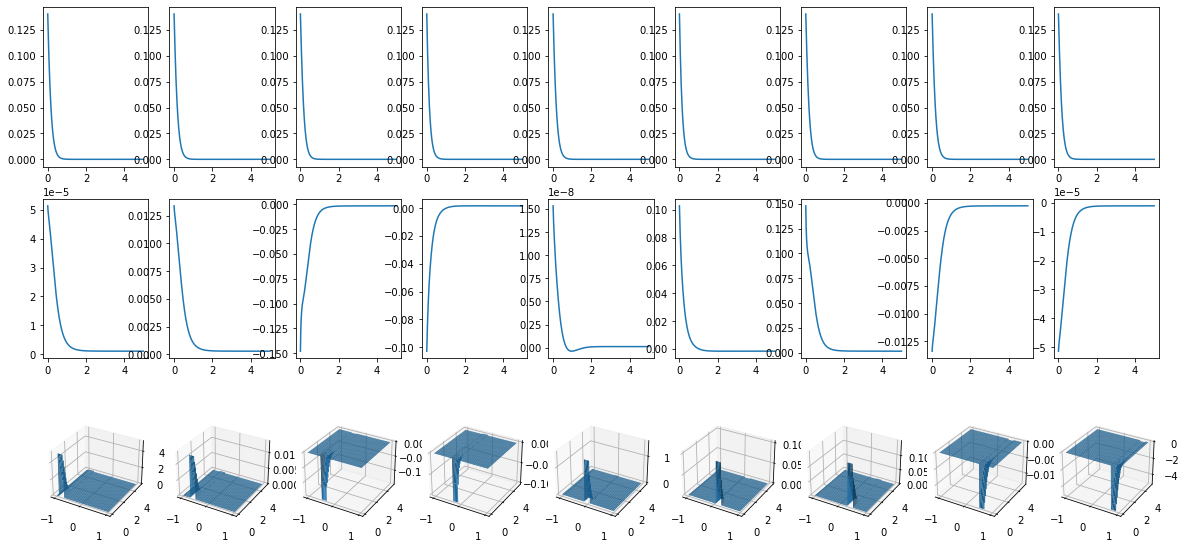

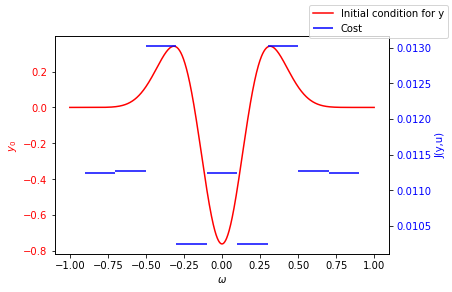

In [48]:
x = np.linspace(-1, 1, 201)
t = np.linspace(0, 5, 1001)
X, T = np.meshgrid(x,t)

h = 0.2
omega_values = np.arange(-1+h,1,h)
G_func = lambda x: x**2
p_0 = lambda x: 0.5*beta(10,10).pdf(x/2+1/2)
interval = [-1.0, 1.0]
parameters = {'v': 0.05, 'T': 5.0, 'p_0': p_0, 'interval': interval}
cost_values = []
u_values = []
y_values = []
alpha_funcs = []

FP_equation = ControlFPequation(G_func, None, parameters)
FP_equation.G_x = lambda x: 2*x

for omega in tqdm(omega_values):
    alpha_func = lambda x: x * (omega - 0.5*h <= x) * (omega + 0.5*h >= x)
    y, cost, u  = FP_equation.solve1d(n_f=20, N_x=1000, N_t=1000, lim1=omega - 0.5*h, lim2=omega + 0.5*h, controlled=True)
    cost_values.append(cost)
    y_values.append(2*(y**2).mean(axis=1))
    u_values.append(u)
    alpha_funcs.append((omega - 0.5*h <= X) * (omega + 0.5*h >= X))

fig = plt.figure(figsize=(20,10))
for i in range(9):
    ax = fig.add_subplot(3, 9, i+1)
    ax.plot(t, y_values[i])
    ax = fig.add_subplot(3, 9, i+10)
    ax.plot(t,u_values[i])
    ax = fig.add_subplot(3, 9, i+19, projection='3d')
    ax.plot_surface(X, T, (alpha_funcs[i].T * u_values[i]).T)
    
plt.show()

fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$y_0$', color=color)
x = np.linspace(-1,1,1000)
ax1.plot(x, p_0(x)-FP_equation.p_infty(x), 
         label='Initial condition for y', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('J(y,u)', color=color)
for i, omega in enumerate(omega_values):
    if i != 0:
        label = ''
    else:
        label = 'Cost'
    ax2.hlines(cost_values[i], xmin=omega-h/2, xmax=omega+h/2, label=label, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.legend()
plt.show()